In [1]:
import tensorflow as tf### models
import numpy as np### math computations
import matplotlib.pyplot as plt### plotting bar chart
import sklearn### machine learning library
import cv2## image processing
from sklearn.metrics import confusion_matrix, roc_curve### metrics
import seaborn as sns### visualizations
import datetime
import pathlib
import io
import os
import time
import random
from PIL import Image
import albumentations as A
import tensorflow_probability as tfp
import matplotlib.cm as cm
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import (GlobalAveragePooling2D, Activation, MaxPooling2D, Add, Conv2D, MaxPool2D, Dense,
                                     Flatten, InputLayer, BatchNormalization, Input, Embedding, Permute,
                                     Dropout, RandomFlip, RandomRotation, LayerNormalization, MultiHeadAttention,
                                     RandomContrast, Rescaling, Resizing, Reshape)
from tensorflow.keras.losses import CategoricalCrossentropy, SparseCategoricalCrossentropy
from tensorflow.keras.metrics import TopKCategoricalAccuracy, CategoricalAccuracy, SparseCategoricalAccuracy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import (Callback, CSVLogger, EarlyStopping, LearningRateScheduler,
                                        ModelCheckpoint, ReduceLROnPlateau)
from tensorflow.keras.regularizers  import L2, L1
from tensorflow.train import BytesList, FloatList, Int64List
from tensorflow.train import Example, Features, Feature

## Getting the Data

In [2]:
!pip install -q kaggle


[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: pip install --upgrade pip


In [4]:
!chmod 600 ~/.kaggle

In [11]:
!mkdir .kaggle/
!cp kaggle.json .kaggle/

mkdir: cannot create directory ‘.kaggle/’: File exists


In [14]:
!ls

Human_Eotion_detection.ipynb  kaggle.json


In [17]:
!kaggle datasets download -d muhammadhananasghar/human-emotions-datasethes

/bin/bash: kaggle: command not found


In [ ]:
!unzip 'human-emotions-datasethes.zip' -d 'dataset/'

In [20]:
!rm human-emotions-datasethes.zip

## Getting a training and testing dataset

In [3]:
train_dir = 'dataset/Emotions Dataset/Emotions Dataset/train'
val_dir = 'dataset/Emotions Dataset/Emotions Dataset/test'
CLASS_NAMES = ['angry', 'happy', 'sad']

In [4]:
CONFIGURATION = {
    "BATCH_SIZE": 32,
    "IM_SIZE": 256,
    "LEARNING_RATE": 1e-3,
    "N_EPOCHS": 20,
    "DROPOUT_RATE": 0.0,
    "REGULARIZATION_RATE": 0.0,
    "N_FILTERS": 6,
    "KERNEL_SIZE": 3,
    "N_STRIDES": 1,
    "POOL_SIZE": 2,
    "N_DENSE_1": 1024,
    "N_DENSE_2": 128,
    "NUM_CLASSES": 3,
    "PATCH_SIZE": 16,
    "PROJ_DIM": 768,
    "N_CLASSES": 3, 
    "CLASS_NAMES": ["angry", "happy", "sad"],
}

## Dataset Loading

In [5]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
    directory=train_dir,
    labels='inferred',
    label_mode='categorical',
    class_names=CONFIGURATION['CLASS_NAMES'],
    color_mode='rgb',
    batch_size=32,
    image_size=(256, 256),
    shuffle=True,
    seed=99
)

Found 6799 files belonging to 3 classes.


In [6]:
train_dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))>

In [7]:
len(train_dataset)

213

In [8]:
val_dataset = tf.keras.utils.image_dataset_from_directory(
    directory=val_dir,
    labels='inferred',
    label_mode='categorical',
    class_names=CONFIGURATION['CLASS_NAMES'],
    color_mode='rgb',
    batch_size=CONFIGURATION['BATCH_SIZE'],
    image_size=(CONFIGURATION['IM_SIZE'], CONFIGURATION['IM_SIZE']),
    shuffle=True,
    seed=99
)

Found 2278 files belonging to 3 classes.


In [9]:
len(val_dataset)

72

## Dataset Visualization

In [10]:
print('test')

test


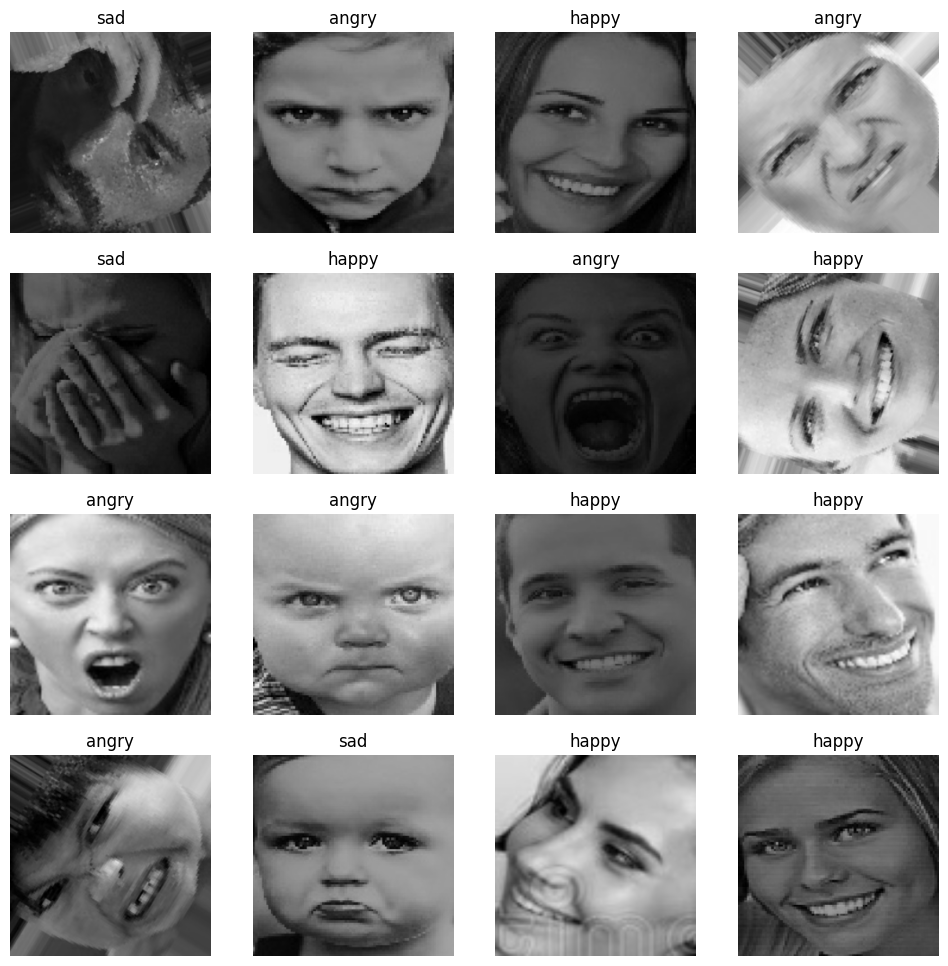

In [11]:
plt.figure(figsize=(12,12))
for image, labels in train_dataset.take(1):
  for i in range(16):
    ax = plt.subplot(4, 4, i+1)
    plt.imshow(image[i]/255.)
    plt.title(CLASS_NAMES[tf.argmax(labels[i], axis=0).numpy()])
    plt.axis('off')

## Data augmentation

In [13]:
augment_layers = tf.keras.Sequential([
       RandomRotation(factor = (-0.025, 0.025),),
       RandomFlip(mode='horizontal',),
       RandomContrast(factor=0.1),
                                  
])
def augment_layer(image, label):
    return augment_layers(image, training=True), label

### Cutmix augmentation

In [12]:
def box(lamda):
  
  r_x = tf.cast(tfp.distributions.Uniform(0, CONFIGURATION["IM_SIZE"]).sample(1)[0], dtype = tf.int32)
  r_y = tf.cast(tfp.distributions.Uniform(0, CONFIGURATION["IM_SIZE"]).sample(1)[0], dtype = tf.int32)

  r_w = tf.cast(CONFIGURATION["IM_SIZE"]*tf.math.sqrt(1-lamda), dtype = tf.int32)
  r_h = tf.cast(CONFIGURATION["IM_SIZE"]*tf.math.sqrt(1-lamda), dtype = tf.int32)

  r_x = tf.clip_by_value(r_x - r_w//2, 0, CONFIGURATION["IM_SIZE"])
  r_y = tf.clip_by_value(r_y - r_h//2, 0, CONFIGURATION["IM_SIZE"])

  x_b_r = tf.clip_by_value(r_x + r_w//2, 0, CONFIGURATION["IM_SIZE"])
  y_b_r = tf.clip_by_value(r_y + r_h//2, 0, CONFIGURATION["IM_SIZE"])

  r_w = x_b_r - r_x
  if(r_w == 0):
    r_w  = 1

  r_h = y_b_r - r_y
  if(r_h == 0):
    r_h = 1

  return r_y, r_x, r_h, r_w

In [13]:
def cutmix(train_dataset_1, train_dataset_2):
  (image_1,label_1), (image_2, label_2) = train_dataset_1, train_dataset_2

  lamda = tfp.distributions.Beta(2,2)
  lamda = lamda.sample(1)[0]
  
  r_y, r_x, r_h, r_w = box(lamda)
  crop_2 = tf.image.crop_to_bounding_box(image_2, r_y, r_x, r_h, r_w)
  pad_2 = tf.image.pad_to_bounding_box(crop_2, r_y, r_x, CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"])

  crop_1 = tf.image.crop_to_bounding_box(image_1, r_y, r_x, r_h, r_w)
  pad_1 = tf.image.pad_to_bounding_box(crop_1, r_y, r_x, CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"])

  image = image_1 - pad_1 + pad_2

  lamda = tf.cast(1- (r_w*r_h)/(CONFIGURATION["IM_SIZE"]*CONFIGURATION["IM_SIZE"]), dtype = tf.float32)
  label = lamda*tf.cast(label_1, dtype = tf.float32) + (1-lamda)*tf.cast(label_2, dtype = tf.float32)

  return image, label

In [14]:
train_dataset_1 = train_dataset.map(augment_layer, num_parallel_calls = tf.data.AUTOTUNE)
train_dataset_2 = train_dataset.map(augment_layer, num_parallel_calls = tf.data.AUTOTUNE)

mixed_dataset = tf.data.Dataset.zip((train_dataset_1, train_dataset_2))

In [15]:
# for cutmix usage
BATCH_SIZE = 32
train_dataset = (
    mixed_dataset
    .map(cutmix, num_parallel_calls = tf.data.AUTOTUNE)
    .prefetch(tf.data.AUTOTUNE)
)

In [16]:
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))>

## Dataset Preparation

In [14]:
resize_rescale_layers = tf.keras.Sequential([
       Resizing(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"]),
       Rescaling(1./255),
])

In [15]:
training_dataset =(
    train_dataset
    .map(augment_layer, num_parallel_calls = tf.data.AUTOTUNE)
    .prefetch(tf.data.AUTOTUNE)
)

In [16]:
validation_dataset =(
    val_dataset
    .prefetch(tf.data.AUTOTUNE)
)

## Modeling

### Sequential API

In [91]:
IM_SIZE = CONFIGURATION['IM_SIZE']
DROPOUT_RATE = CONFIGURATION['DROPOUT_RATE']
REGULARIZATION_RATE = CONFIGURATION['REGULARIZATION_RATE']
N_FILTERS = CONFIGURATION['N_FILTERS']
KERNEL_SIZE = CONFIGURATION['KERNEL_SIZE']
POOL_SIZE = CONFIGURATION['POOL_SIZE']
N_STRIDES = CONFIGURATION['N_STRIDES']

lenet_model = tf.keras.Sequential([
    InputLayer(input_shape = (None, None, 3)),
    resize_rescale_layers,
    Conv2D(filters = N_FILTERS , kernel_size = KERNEL_SIZE, strides = N_STRIDES , padding='valid',
          activation = 'relu',kernel_regularizer = L2(REGULARIZATION_RATE)),
    BatchNormalization(),
    MaxPool2D (pool_size = POOL_SIZE, strides= N_STRIDES*2),
    Dropout(rate = DROPOUT_RATE ),

    Conv2D(filters = N_FILTERS*2 + 4, kernel_size = KERNEL_SIZE, strides=N_STRIDES, padding='valid',
          activation = 'relu', kernel_regularizer = L2(REGULARIZATION_RATE)),
    BatchNormalization(),
    MaxPool2D (pool_size = POOL_SIZE, strides= N_STRIDES*2),

    Flatten(),

    Dense( CONFIGURATION['N_DENSE_1'], activation = "relu", kernel_regularizer = L2(REGULARIZATION_RATE)),
    BatchNormalization(),
    Dropout(rate = DROPOUT_RATE),

    Dense( CONFIGURATION['N_DENSE_2'], activation = "relu", kernel_regularizer = L2(REGULARIZATION_RATE)),
    BatchNormalization(),

    Dense(CONFIGURATION['NUM_CLASSES'], activation = "softmax"),

])

lenet_model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_7 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 254, 254, 6)       168       
                                                                 
 batch_normalization_4 (Bat  (None, 254, 254, 6)       24        
 chNormalization)                                                
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 127, 127, 6)       0         
 g2D)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 127, 127, 6)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 125, 125, 16)     

### Resnet34

#### Customconv2D 

In [93]:
class CustomConv2D(Layer):
    def __init__(self, n_filters, kernel_size, n_strides, padding='valid', activation = 'relu'):
        super(CustomConv2D, self).__init__(name = 'custom_conv2D')
        self.conv = Conv2D(
            filters = n_filters,
            kernel_size = kernel_size,
            activation = activation,
            strides = n_strides,
            padding = padding            
        )
        self.batch_norm = BatchNormalization()
    
    def call(self, x, training=True):
        x = self.conv(x)
        x = self.batch_norm(x, training)
        
        return x

#### Residual Block

In [94]:
class ResidualBlock(Layer):
    def __init__(self, n_channels, n_strides = 1):
        super(ResidualBlock, self).__init__(name= 'res_block')
        self.dotted = (n_strides != 1)
        
        self.custom_conv_1 = CustomConv2D(n_channels, 3, n_strides, padding='same')
        self.custom_conv_2 = CustomConv2D(n_channels, 3, 1, padding='same')
        
        self.activation = Activation('relu')
        
        if self.dotted:
            self.custom_conv_3 = CustomConv2D(n_channels, 1, n_strides)
    
    def call(self, input, training=True):
        
        x = self.custom_conv_1(input, training)
        x = self.custom_conv_2(x, training)
        
        if self.dotted:
            x_add = self.custom_conv_3(input, training)
            x_add = Add()([x, x_add])
        else:
            x_add = Add()([x, input])
        
        return self.activation(x_add)
        

#### Full Network

In [95]:
class ResNet34(Model):
    def __init__(self):
        super(ResNet34, self).__init__(name = 'resnet_34')
        self.conv_1 = CustomConv2D(64, 7, 2, padding='same')
        self.max_pool = MaxPooling2D(3, 2)
        
        self.conv_2_1 = ResidualBlock(64)
        self.conv_2_2 = ResidualBlock(64)
        self.conv_2_3 = ResidualBlock(64)
        
        self.conv_3_1 = ResidualBlock(128, 2)
        self.conv_3_2 = ResidualBlock(128)
        self.conv_3_3 = ResidualBlock(128)
        self.conv_3_4 = ResidualBlock(128)
        
        self.conv_4_1 = ResidualBlock(256, 2)
        self.conv_4_2 = ResidualBlock(256)
        self.conv_4_3 = ResidualBlock(256)
        self.conv_4_4 = ResidualBlock(256)
        self.conv_4_5 = ResidualBlock(256)
        self.conv_4_6 = ResidualBlock(256)
        
        self.conv_5_1 = ResidualBlock(512, 2)
        self.conv_5_2 = ResidualBlock(512)
        self.conv_5_3 = ResidualBlock(512)
        
        self.global_pool = GlobalAveragePooling2D()
        
        self.fc_3 = Dense(CONFIGURATION['NUM_CLASSES'], activation='softmax')
    
    def call(self, x, training = True):
        x = self.conv_1(x)
        x = self.max_pool(x)
        
        x = self.conv_2_1(x,training)
        x = self.conv_2_2(x, training)
        x = self.conv_2_3(x, training)
        
        x = self.conv_3_1(x, training)
        x = self.conv_3_2(x, training)
        x = self.conv_3_3(x, training)
        x = self.conv_3_4(x, training)
        
        x = self.conv_4_1(x, training)
        x = self.conv_4_2(x, training)
        x = self.conv_4_3(x, training)
        x = self.conv_4_4(x, training)
        x = self.conv_4_5(x, training)
        x = self.conv_4_6(x, training)
        
        x = self.conv_5_1(x, training)
        x = self.conv_5_2(x, training)
        x = self.conv_5_3(x, training)
        
        x = self.global_pool(x)
        return self.fc_3(x)
        

In [98]:
resnet_34 = ResNet34()
resnet_34(tf.zeros([1, 256, 256, 3]), training=False)
resnet_34.summary()

Model: "resnet_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 custom_conv2D (CustomConv2  multiple                  9728      
 D)                                                              
                                                                 
 max_pooling2d_5 (MaxPoolin  multiple                  0         
 g2D)                                                            
                                                                 
 res_block (ResidualBlock)   multiple                  74368     
                                                                 
 res_block (ResidualBlock)   multiple                  74368     
                                                                 
 res_block (ResidualBlock)   multiple                  74368     
                                                                 
 res_block (ResidualBlock)   multiple                  23

### Transfer learning with efficeent net

In [17]:
backbone = tf.keras.applications.efficientnet.EfficientNetB4(
    include_top=False,
    weights='imagenet',
    input_shape=(CONFIGURATION['IM_SIZE'], CONFIGURATION['IM_SIZE'], 3)
)

In [18]:
backbone.trainable = False

In [19]:
backbone.summary()

Model: "efficientnetb4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 rescaling_2 (Rescaling)     (None, 256, 256, 3)          0         ['input_1[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, 256, 256, 3)          7         ['rescaling_2[0][0]']         
 on)                                                                                              
                                                                                                  
 rescaling_3 (Rescaling)     (None, 256, 256, 3)          0         ['normalization[0

In [20]:
model = tf.keras.Sequential([
    InputLayer(input_shape = (None, None, 3)),
    resize_rescale_layers,
    backbone,
    GlobalAveragePooling2D(),
    Dense(CONFIGURATION['N_DENSE_1'], activation='relu'),
    BatchNormalization(),
    Dense(CONFIGURATION['N_DENSE_2'], activation='relu'),
    Dense(CONFIGURATION["NUM_CLASSES"], activation='softmax')
])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 efficientnetb4 (Functional  (None, 8, 8, 1792)        17673823  
 )                                                               
                                                                 
 global_average_pooling2d (  (None, 1792)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 1024)              1836032   
                                                                 
 batch_normalization (Batch  (None, 1024)              4096      
 Normalization)                                                  
                                                      

### Finetuning Efficient net

In [25]:
backbone.trainable = False

In [26]:
_input = Input(shape = (None, None, 3))
x = resize_rescale_layers(_input)
x = backbone(x, training = False)
x =  GlobalAveragePooling2D()(x)
x = Dense(CONFIGURATION['N_DENSE_1'], activation='relu')(x)
x = BatchNormalization()(x)
x = Dense(CONFIGURATION['N_DENSE_2'], activation='relu')(x)
output  = Dense(CONFIGURATION["NUM_CLASSES"], activation='softmax')(x)

finetunes_model = Model(_input, output)

In [24]:
finetunes_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 sequential_2 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 efficientnetb4 (Functional  (None, 8, 8, 1792)        17673823  
 )                                                               
                                                                 
 global_average_pooling2d_1  (None, 1792)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_3 (Dense)             (None, 1024)              1836032   
                                                                 
 batch_normalization_1 (Bat  (None, 1024)              4096  

### ViTS FROM SCRATCH

In [21]:
test_image = cv2.imread('./dataset/Emotions Dataset/Emotions Dataset/test/sad/105052.jpg_brightness_1.jpg')
test_image = cv2.resize(test_image, (CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"]))

In [22]:
 patches = tf.image.extract_patches(images=tf.expand_dims(test_image, axis = 0),
                           sizes=[1, CONFIGURATION['PATCH_SIZE'], CONFIGURATION['PATCH_SIZE'], 1],
                           strides=[1, CONFIGURATION['PATCH_SIZE'], CONFIGURATION['PATCH_SIZE'], 1],
                           rates=[1, 1, 1, 1],
                           padding='VALID')

In [29]:
print(patches.shape)
patches = tf.reshape(patches, (patches.shape[0], -1, 768))
print(patches.shape)

(1, 16, 16, 768)
(1, 256, 768)


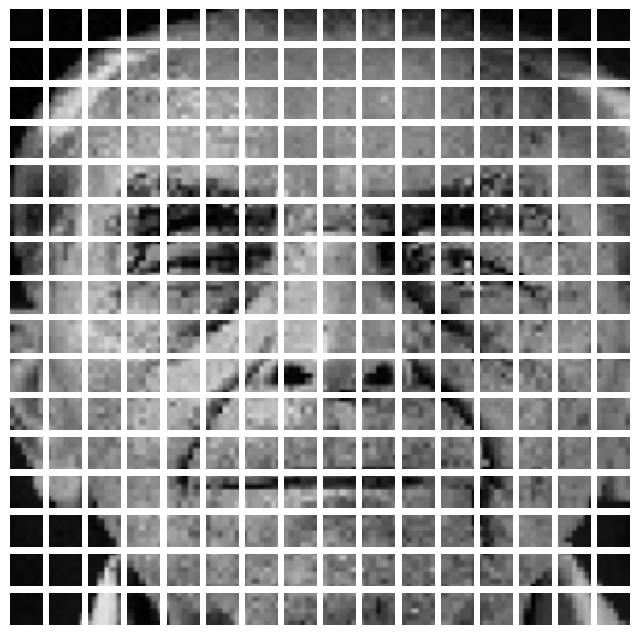

In [33]:
plt.figure(figsize = (8,8))
for i in range(patches.shape[1]):
    ax = plt.subplot(16, 16, i+1)
    plt.imshow(tf.reshape(patches[0, i, :], (16, 16, 3)))
    plt.axis('off')

In [38]:
class PatchEncoder(Layer):
    def __init__(self, n_patches, hidden_size):
        super(PatchEncoder, self).__init__(name = 'PatchEncoder')
        self.linear_projection = Dense(hidden_size)
        self.positional_embedding = Embedding(n_patches, hidden_size)
        self.n_patches = n_patches
    
    
    def call(self, x):
        patches = tf.image.extract_patches(images=x,
                           sizes=[1, CONFIGURATION['PATCH_SIZE'], CONFIGURATION['PATCH_SIZE'], 1],
                           strides=[1, CONFIGURATION['PATCH_SIZE'], CONFIGURATION['PATCH_SIZE'], 1],
                           rates=[1, 1, 1, 1],
                           padding='VALID')
        patches = tf.reshape(patches, (patches.shape[0], -1, patches.shape[-1]))
        embedding_input = tf.range(start=0, limit =self.n_patches, delta = 1)
        output = self.linear_projection(patches) + self.positional_embedding(embedding_input)
        
        return output

In [ ]:
patch_enc = PatchEncoder(256, 768)
patch_enc(tf.)

## Training

In [38]:
checkpoint_callback = ModelCheckpoint(
    'best_weights', 
    monitor='val_accuracy',
    mode = 'max',
    verbose=1, 
    save_best_only=True,
    
    )

In [39]:
loss_function = CategoricalCrossentropy()

In [40]:
metrics = [CategoricalAccuracy(name = 'accuracy'),TopKCategoricalAccuracy(k= 2, name='top_k_accuracy')]

In [41]:
model.compile(
    optimizer = Adam(learning_rate = CONFIGURATION['LEARNING_RATE']),
    loss = loss_function,
    metrics = metrics
)

In [ ]:
history = model.fit(
    training_dataset,
    validation_data = validation_dataset,
    epochs= CONFIGURATION['N_EPOCHS']*3,
    verbose = 1,
    callbacks = [checkpoint_callback])

Epoch 1/60
213/213 [==============================] - ETA: 0s - loss: 1.1896 - accuracy: 0.3915 - top_k_accuracy: 0.7254
Epoch 1: val_accuracy improved from -inf to 0.22608, saving model to best_weights
INFO:tensorflow:Assets written to: best_weights/assets


INFO:tensorflow:Assets written to: best_weights/assets


213/213 [==============================] - 1071s 5s/step - loss: 1.1896 - accuracy: 0.3915 - top_k_accuracy: 0.7254 - val_loss: 1.3897 - val_accuracy: 0.2261 - val_top_k_accuracy: 0.5544
Epoch 2/60
213/213 [==============================] - ETA: 0s - loss: 1.1428 - accuracy: 0.4039 - top_k_accuracy: 0.7305
Epoch 2: val_accuracy improved from 0.22608 to 0.44162, saving model to best_weights
INFO:tensorflow:Assets written to: best_weights/assets


INFO:tensorflow:Assets written to: best_weights/assets


213/213 [==============================] - 1051s 5s/step - loss: 1.1428 - accuracy: 0.4039 - top_k_accuracy: 0.7305 - val_loss: 1.1298 - val_accuracy: 0.4416 - val_top_k_accuracy: 0.7739
Epoch 3/60
213/213 [==============================] - ETA: 0s - loss: 1.1056 - accuracy: 0.4084 - top_k_accuracy: 0.7489
Epoch 3: val_accuracy did not improve from 0.44162
213/213 [==============================] - 997s 5s/step - loss: 1.1056 - accuracy: 0.4084 - top_k_accuracy: 0.7489 - val_loss: 1.0885 - val_accuracy: 0.3336 - val_top_k_accuracy: 0.7766
Epoch 4/60
213/213 [==============================] - ETA: 0s - loss: 1.0881 - accuracy: 0.4258 - top_k_accuracy: 0.7557
Epoch 4: val_accuracy did not improve from 0.44162
213/213 [==============================] - 1007s 5s/step - loss: 1.0881 - accuracy: 0.4258 - top_k_accuracy: 0.7557 - val_loss: 1.1438 - val_accuracy: 0.4416 - val_top_k_accuracy: 0.7739
Epoch 5/60
213/213 [==============================] - ETA: 0s - loss: 1.0773 - accuracy: 0.4264 

In [94]:
lenet_model.compile(
    optimizer = Adam(learning_rate = CONFIGURATION['LEARNING_RATE']),
    loss= loss_function,
    metrics = metrics,
)



In [ ]:
history = lenet_model.fit(
    training_dataset,
    validation_data = validation_dataset,
    epochs= 10,
    verbose = 1
)

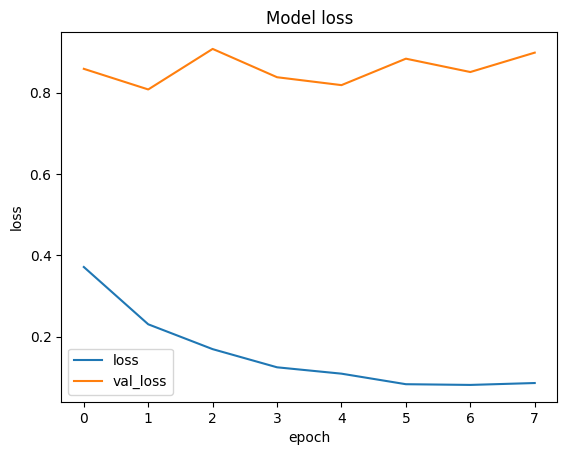

In [39]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Model loss")
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss', 'val_loss'])
plt.show()

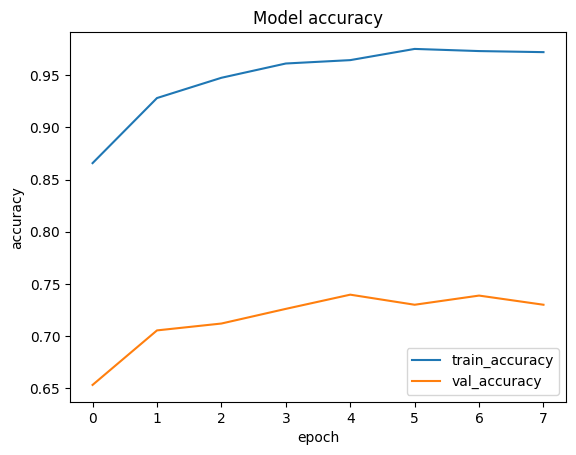

In [40]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("Model accuracy")
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_accuracy', 'val_accuracy'])
plt.show()

## Visualization

In [14]:
vgg_backbone = tf.keras.applications.vgg16.VGG16(
    include_top=False,
    weights='imagenet',
    input_shape=(CONFIGURATION['IM_SIZE'], CONFIGURATION['IM_SIZE'], 3),
)

In [15]:
vgg_backbone.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

In [16]:
def is_conv(layer_name):
    if 'conv' in layer_name:
        return True
    else:
        return False

In [17]:
feature_maps = [layer.output for layer in vgg_backbone.layers[1:] if is_conv(layer.name)]
feature_map_model = Model(
    inputs = vgg_backbone.input,
    outputs = feature_maps
)

feature_map_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

In [18]:
test_image  = cv2.imread('dataset/Emotions Dataset/Emotions Dataset/train/happy/402929.jpg_rotation_1.jpg')
test_image = cv2.resize(test_image, (CONFIGURATION['IM_SIZE'], CONFIGURATION['IM_SIZE']))

im = tf.constant(test_image, dtype = tf.float32)
im = tf.expand_dims(im, axis=0)

f_maps = feature_map_model.predict(im)

1/1 [==============================] - 1s 604ms/step


In [19]:
for i in range(len(f_maps)):
    print(f_maps[i].shape)

(1, 256, 256, 64)
(1, 256, 256, 64)
(1, 128, 128, 128)
(1, 128, 128, 128)
(1, 64, 64, 256)
(1, 64, 64, 256)
(1, 64, 64, 256)
(1, 32, 32, 512)
(1, 32, 32, 512)
(1, 32, 32, 512)
(1, 16, 16, 512)
(1, 16, 16, 512)
(1, 16, 16, 512)


In [ ]:
for i in range(len(f_maps)):
    plt.figure(figsize = (256, 256))
    f_size = f_maps[i].shape[1]
    n_channels = f_maps[i].shape[3]
    joint_maps = np.ones((f_size, f_size*n_channels))
    axs = plt.subplot(len(f_maps), 1, i+1)
    for j in range(n_channels):
        joint_maps[:, f_size*j:f_size*(j+1)] = f_maps[i][..., j]
    plt.imshow(joint_maps[:,0:512])
    plt.axis('off')
        

## Testing

In [45]:
test_image  = cv2.imread('dataset/Emotions Dataset/Emotions Dataset/train/happy/402929.jpg_rotation_1.jpg')
im = tf.constant(test_image, dtype=tf.float32)
im = tf.expand_dims(im, axis=0)
result = tf.argmax(lenet_model(im), axis=-1).numpy()
print(result)
print(CLASS_NAMES[result[0]])



[1]
happy


TensorShape([1, 224, 224, 3])

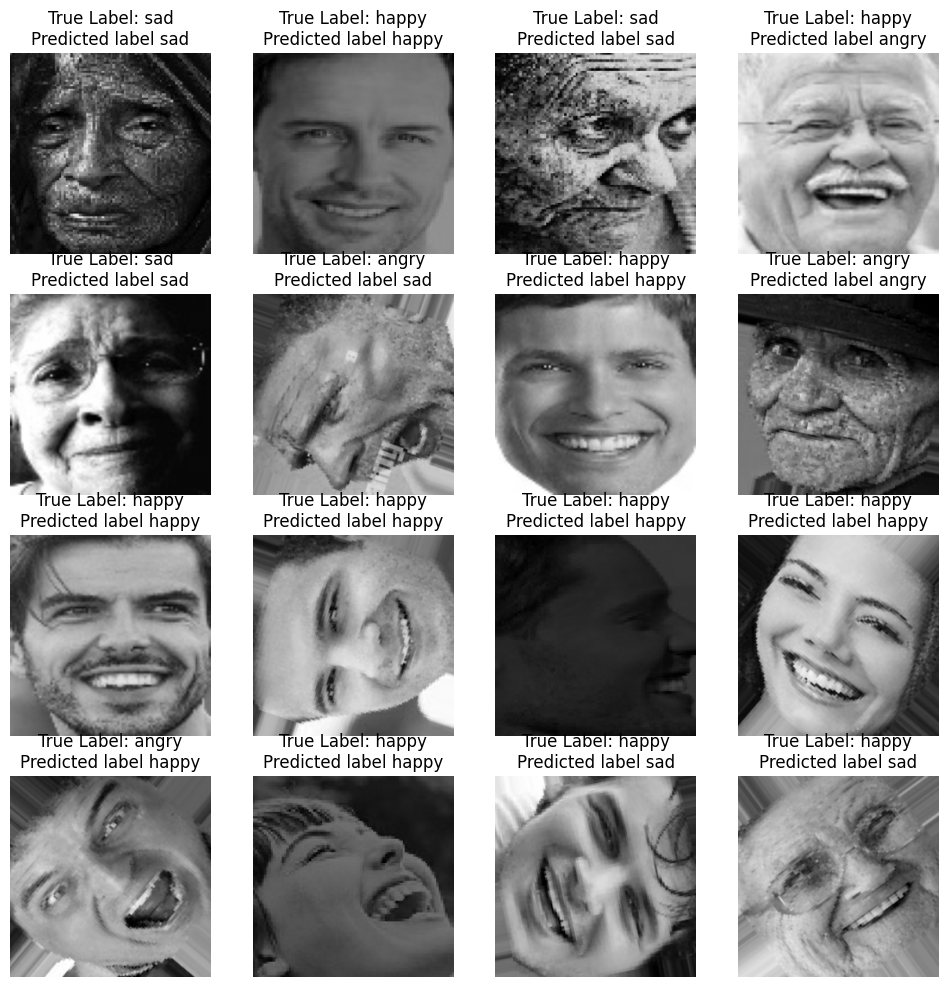

In [59]:
plt.figure(figsize=(12,12))
for image, labels in validation_dataset.take(1):
  for i in range(16):
    ax = plt.subplot(4, 4, i+1)
    plt.imshow(image[i]/255.)
    label = CLASS_NAMES[tf.argmax(labels[i], axis=0).numpy()]
    prediction = CLASS_NAMES[tf.argmax(lenet_model(tf.expand_dims(image[i], axis=0)), axis=-1).numpy()[0]]
    plt.title(f'True Label: {label}\nPredicted label {prediction}')
    plt.axis('off')

## Confusion Matrix

In [66]:
predicted = []
labels  = []
for im, label in validation_dataset:
    predicted.append(lenet_model(im))
    labels.append(label.numpy())
    

In [67]:
print(np.argmax(labels[:-1], axis=-1).flatten())
print(np.argmax(predicted[:-1], axis=-1).flatten())

[0 0 1 ... 2 0 2]
[0 0 2 ... 2 0 2]


In [75]:
pred = np.concatenate([np.argmax(predicted[:-1], axis=-1).flatten(), np.argmax(predicted[-1], axis=-1).flatten()])
lab = np.concatenate([np.argmax(labels[:-1], axis=-1).flatten(), np.argmax(labels[-1], axis=-1).flatten()])

In [76]:
print(len(pred))
print(len(lab))

2278
2278


[[322  76 117]
 [ 67 758 181]
 [ 68 106 583]]


Text(0.5, 58.7222222222222, 'Predicted')

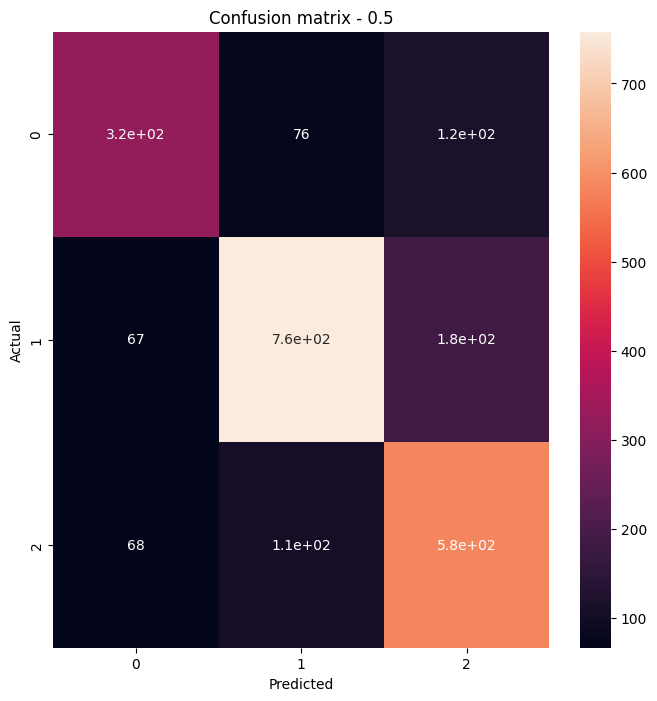

In [77]:
threshold = 0.5

cm = confusion_matrix(lab, pred)
print(cm)
plt.figure(figsize=(8,8))

sns.heatmap(cm, annot=True,)
plt.title('Confusion matrix - {}'.format(threshold))
plt.ylabel('Actual')
plt.xlabel('Predicted')

## TFRecords

In [16]:
training_dataset = (
    training_dataset
    .unbatch() 
)

In [17]:
validation_dataset = (
    validation_dataset
    .unbatch() 
)

In [18]:
training_dataset

<_UnbatchDataset element_spec=(TensorSpec(shape=(256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(3,), dtype=tf.float32, name=None))>

In [19]:
validation_dataset

<_UnbatchDataset element_spec=(TensorSpec(shape=(256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(3,), dtype=tf.float32, name=None))>

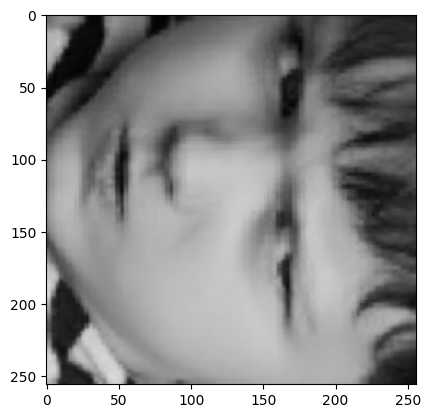

In [20]:
for i in training_dataset.take(1):
    plt.imshow(i[0]/255.)

In [21]:
def create_example(image, label):
    bytes_feature = Feature(
        bytes_list=BytesList(value=[image]))
    int_feature = Feature(
        int64_list=Int64List(value=[label]))


    example = Example(
        features=Features(feature={
            'images': bytes_feature,
            'labels': int_feature,
        }))
    return example.SerializeToString()

In [22]:
def encode_image(image, label):
    image = tf.io.serialize_tensor(image)
    return image,tf.argmax(label)

In [23]:
encoded_dataset = (
    training_dataset
    .map(encode_image)
)

(256, 256, 3)


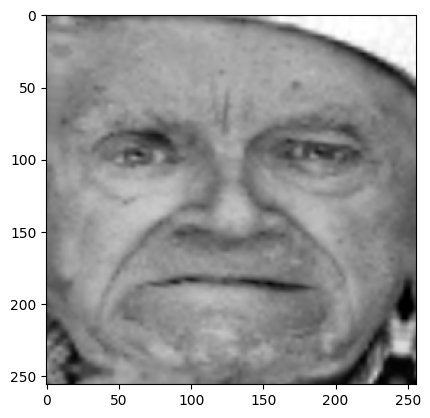

In [27]:
# Example of how to decode images after encodign it
for image, lable in encoded_dataset.take(1):
    decoded_image = tf.io.parse_tensor(image, tf.float32)
    print(decoded_image.shape)
    plt.imshow(decoded_image/255.)

In [31]:
NUM_SHARDS = 10
PATH = 'tfrecords/shard_{:02d}.tfrecord'

In [122]:
# Write the records to a file.
for shard_number in range(NUM_SHARDS):
    sharded_dataset = (
        encoded_dataset
        .shard(NUM_SHARDS, shard_number)
        .as_numpy_iterator()
    )
    with tf.io.TFRecordWriter(PATH.format(shard_number)) as file_writer:
        for encoded_image, encoded_label in sharded_dataset:
            example = create_example(encoded_image, encoded_label)
            file_writer.write(example)

In [32]:
tfrecord_paths = [PATH.format(p) for p in range(NUM_SHARDS)]
print(tfrecord_paths)

['tfrecords/shard_00.tfrecord', 'tfrecords/shard_01.tfrecord', 'tfrecords/shard_02.tfrecord', 'tfrecords/shard_03.tfrecord', 'tfrecords/shard_04.tfrecord', 'tfrecords/shard_05.tfrecord', 'tfrecords/shard_06.tfrecord', 'tfrecords/shard_07.tfrecord', 'tfrecords/shard_08.tfrecord', 'tfrecords/shard_09.tfrecord']


In [33]:
recons_dataset = tf.data.TFRecordDataset(filenames= [tfrecord_paths])

In [53]:
def parse_tfrecords(example):
    feauture_description = {
        'images': tf.io.FixedLenFeature([], tf.string),
        'labels': tf.io.FixedLenFeature([], tf.int64)
    }
    example = tf.io.parse_single_example(example, feauture_description)
    example["images"] = tf.io.parse_tensor(example["images"], tf.float32)
    example['labels'] = tf.one_hot(example['labels'], 3)
    return example['images'], example['labels']
    

In [54]:
parsed_dataset = (
    recons_dataset
    .map(parse_tfrecords)
    .batch(CONFIGURATION['BATCH_SIZE'])
    .prefetch(tf.data.AUTOTUNE)
)

In [55]:
parsed_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=<unknown>, dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))>

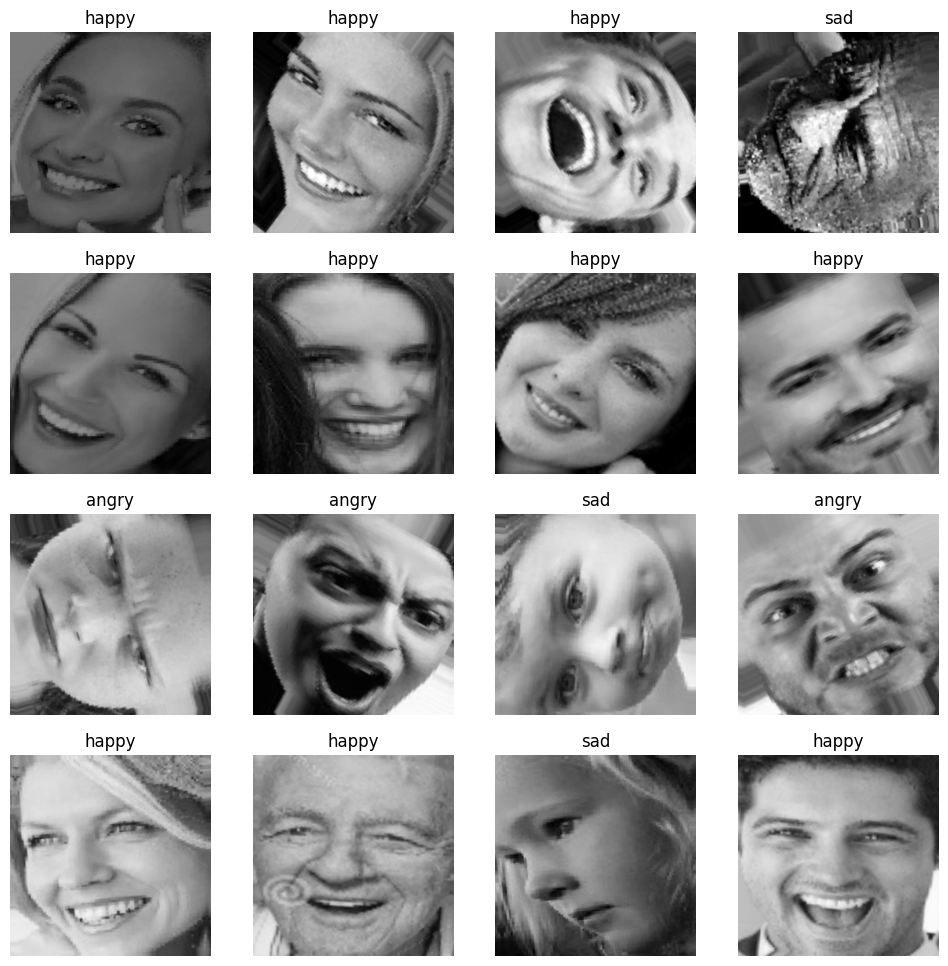

In [57]:
plt.figure(figsize=(12,12))
for image, labels in parsed_dataset.take(1):
  for i in range(16):
    ax = plt.subplot(4, 4, i+1)
    plt.imshow(image[i]/255.)
    plt.title(CLASS_NAMES[tf.argmax(labels[i], axis=0).numpy()])
    plt.axis('off')
    